# Weber Fractions and JNDs Analysis: Cross-Modal Temporal Discrimination

This notebook analyzes Weber fractions and Just Noticeable Differences (JNDs) across unimodal auditory and visual temporal discrimination conditions to examine cue reliability effects and cross-modal precision differences.

## Overview
- **Visual condition**: High-quality visual stimuli (baseline)
- **Auditory high reliability**: Low noise (0.1) 
- **Auditory low reliability**: High noise (1.2)
- **Standard duration**: 500ms across all conditions

## 1. Import Libraries and Setup

In [18]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

print("✓ Libraries imported successfully")

# Set global parameters
STANDARD_DURATION = 0.5  # 500ms standard duration
FONT_SIZE = 14
TITLE_SIZE = 16

✓ Libraries imported successfully


In [ ]:
# Load individual participant log-normal fits
# Model: P(choose test) = λ/2 + (1-λ) * Φ((ln(test/standard) - μ) / σ)
# Toggle FIXED_MU to match the re-fitting cell

import scipy.io, os
from scipy.stats import wilcoxon, friedmanchisquare

# ====================== CONFIGURATION ======================
FIXED_MU = True           # Must match the re-fitting cell
MIN_TEST_DUR_S = 0     # Must match the re-fitting cell
SIGMA_CUTOFF = 10          # Exclude participants with any σ > this value
# ============================================================

_mu_str = "fixedMu" if FIXED_MU else "freeMu"
_filt_str = "_filtered" if MIN_TEST_DUR_S > 0 else ""
FIT_SUFFIX = f"_fits_logNormal_{_mu_str}{_filt_str}"

participant_ids = ['as', 'dt', 'hh', 'ip', 'ln2', 'mh', 'ml', 'mt', 'oy', 'qs', 'sx', 'ln1']
data_dir = "data/"

sigma_visual_list, mu_visual_list = [], []
sigma_auditory_high_list, sigma_auditory_low_list = [], []
mu_auditory_high_list, mu_auditory_low_list = [], []
valid_participants = []

for pid in participant_ids:
    try:
        aud_data = scipy.io.loadmat(os.path.join(data_dir, f"{pid}_auditory{FIT_SUFFIX}.mat"))
        vis_data = scipy.io.loadmat(os.path.join(data_dir, f"{pid}_visual{FIT_SUFFIX}.mat"))
        aud_params = aud_data['fittedParams'].flatten()
        vis_params = vis_data['fittedParams'].flatten()
        
        # Layout always: [lambda, sigma1, sigma2, mu1, mu2] (mu=0 when fixedMu)
        sigma_auditory_high_list.append(aud_params[1])
        sigma_auditory_low_list.append(aud_params[2])
        mu_auditory_high_list.append(aud_params[3])
        mu_auditory_low_list.append(aud_params[4])
        # Visual: [lambda, sigma, mu]
        sigma_visual_list.append(vis_params[1])
        mu_visual_list.append(vis_params[2])
        valid_participants.append(pid)
    except Exception as e:
        print(f"Skipped {pid}: {e}")

sigma_visual = np.array(sigma_visual_list)
mu_visual = np.array(mu_visual_list)
sigma_auditory_high = np.array(sigma_auditory_high_list)
sigma_auditory_low = np.array(sigma_auditory_low_list)
mu_auditory_high = np.array(mu_auditory_high_list)
mu_auditory_low = np.array(mu_auditory_low_list)

# Exclude participants with any σ > SIGMA_CUTOFF
keep_mask = (sigma_visual <= SIGMA_CUTOFF) & (sigma_auditory_high <= SIGMA_CUTOFF) & (sigma_auditory_low <= SIGMA_CUTOFF)
excluded = [pid for pid, k in zip(valid_participants, keep_mask) if not k]
if excluded:
    print(f"\nExcluded {len(excluded)} participant(s) with σ > {SIGMA_CUTOFF}: {excluded}")
    for pid in excluded:
        idx = valid_participants.index(pid)
        print(f"  {pid}: σ_vis={sigma_visual[idx]:.3f}, σ_aud_high={sigma_auditory_high[idx]:.3f}, σ_aud_low={sigma_auditory_low[idx]:.3f}")

sigma_visual = sigma_visual[keep_mask]
mu_visual = mu_visual[keep_mask]
sigma_auditory_high = sigma_auditory_high[keep_mask]
sigma_auditory_low = sigma_auditory_low[keep_mask]
mu_auditory_high = mu_auditory_high[keep_mask]
mu_auditory_low = mu_auditory_low[keep_mask]
valid_participants = [pid for pid, k in zip(valid_participants, keep_mask) if k]
n_participants = len(valid_participants)

# ============================================================================
# CONVERSION FUNCTIONS
# ============================================================================
# When μ=0 (fixedMu):
#   SD  = T_std × √(exp(σ²) - 1) × exp(σ²/2)    [simplifies from full formula]
#   JND = T_std × (exp(0.6745σ) - 1)
#   Weber = √(exp(σ²) - 1)
# When μ free:
#   SD  = T_std × √[(exp(σ²) - 1) × exp(2μ + σ²)]
#   JND = T_std × exp(μ) × (exp(0.6745σ) - 1)
# ============================================================================

standard_dur_s = 0.5
z_75 = 0.6745

def log_to_linear_sd_s(sigma_log, mu_log):
    """SD in seconds."""
    var_lin = np.exp(2*mu_log + sigma_log**2) * (np.exp(sigma_log**2) - 1)
    return np.sqrt(var_lin) * standard_dur_s

def log_to_weber(sigma_log):
    """Weber fraction (CV): √(exp(σ²) - 1)"""
    return np.sqrt(np.exp(sigma_log**2) - 1)

def log_to_jnd_s(sigma_log, mu_log) :
    """JND at 75% in seconds."""
    return standard_dur_s * np.exp(mu_log) * (np.exp(z_75 * sigma_log) - 1)

def log_to_pse_shift_s(mu_log):
    """PSE shift in seconds."""
    return standard_dur_s * (np.exp(mu_log) - 1)

# ============================================================================
# REPORT
# ============================================================================
print(f"Loaded {n_participants} participants: {valid_participants}")
print(f"Suffix: {FIT_SUFFIX}  |  FIXED_MU={FIXED_MU}")

conditions = [
    ("Aud High Rel (0.1)", sigma_auditory_high, mu_auditory_high),
    ("Visual",             sigma_visual,        mu_visual),
    ("Aud Low Rel (1.2)",  sigma_auditory_low,  mu_auditory_low),
]

print("="*65)
print(" MEDIAN σ AND μ")
print("="*65)
for name, sig, mu in conditions:
    line = f"  {name:<20s}  σ = {np.median(sig):.4f}  (IQR {np.percentile(sig,25):.4f}–{np.percentile(sig,75):.4f})"
    if not FIXED_MU:
        line += f"   μ = {np.median(mu):.4f}"
    print(line)

print("\n" + "="*65)
print(" CONVERTED TO LINEAR SPACE using median(σ)" + ("" if FIXED_MU else ", median(μ)"))
print("="*65)
for name, sig, mu in conditions:
    ms  = np.median(sig)
    mm  = np.median(mu)  # 0 when fixedMu
    sd_s  = log_to_linear_sd_s(ms, mm)
    w     = log_to_weber(ms)
    jnd_s = log_to_jnd_s(ms, mm)
    print(f"\n  {name}  (σ={ms:.4f}):")
    print(f"    SD        = {sd_s*1000:.1f} ms")
    #%print(f"    Weber (W) = {w:.f}")
    print(f"    JND 75%   = {jnd_s*1000:.1f} ms")
    if not FIXED_MU:
        pse_s = log_to_pse_shift_s(mm)
        print(f"    PSE shift = {pse_s*1000:.1f} ms")

# Per-person arrays for downstream stats/plots
sd_vis        = log_to_linear_sd_s(sigma_visual, mu_visual) * 1000
sd_aud_high   = log_to_linear_sd_s(sigma_auditory_high, mu_auditory_high) * 1000
sd_aud_low    = log_to_linear_sd_s(sigma_auditory_low, mu_auditory_low) * 1000
weber_vis       = log_to_weber(sigma_visual)
weber_aud_high  = log_to_weber(sigma_auditory_high)
weber_aud_low   = log_to_weber(sigma_auditory_low)
jnd_vis      = log_to_jnd_s(sigma_visual, mu_visual) * 1000
jnd_aud_high = log_to_jnd_s(sigma_auditory_high, mu_auditory_high) * 1000
jnd_aud_low  = log_to_jnd_s(sigma_auditory_low, mu_auditory_low) * 1000
standard_dur_ms = 500

# Per-participant table
print("\n" + "="*65)
print(" PER-PARTICIPANT: σ" + ("" if FIXED_MU else ", μ") + ", SD(ms), JND(ms)")
print("="*65)
if FIXED_MU:
    header = f"  {'PID':>4}  {'σ':>6}  {'SD(ms)':>8}  {'JND(ms)':>8}"
else:
    header = f"  {'PID':>4}  {'σ':>6}  {'μ':>7}  {'SD(ms)':>8}  {'JND(ms)':>8}"

for cond_name, sig, mu in conditions:
    print(f"\n  {cond_name}:")
    print(header)
    for i, pid in enumerate(valid_participants):
        sd_ms  = log_to_linear_sd_s(sig[i], mu[i]) * 1000
        jnd_ms = log_to_jnd_s(sig[i], mu[i]) * 1000
        flag = " ⚠" if sig[i] > 0.8 else ""
        if FIXED_MU:
            print(f"  {pid:>4}  {sig[i]:>6.3f}  {sd_ms:>8.1f}  {jnd_ms:>8.1f}{flag}")
        else:
            flag = " ⚠" if sig[i] > 0.8 or abs(mu[i]) > 0.5 else ""
            print(f"  {pid:>4}  {sig[i]:>6.3f}  {mu[i]:>7.4f}  {sd_ms:>8.1f}  {jnd_ms:>8.1f}{flag}")

# ============================================================================
# WEBER FRACTIONS (WF) — per-participant and summary
# ============================================================================
print("\n" + "="*65)
print(" WEBER FRACTIONS  (WF = √(exp(σ²) − 1))")
print("="*65)

wf_conditions = [
    ("Aud High Rel (0.1)", weber_aud_high),
    ("Visual",             weber_vis),
    ("Aud Low Rel (1.2)",  weber_aud_low),
]

for name, wf in wf_conditions:
    print(f"  {name:<20s}  WF = {np.median(wf):.4f}  "
          f"(IQR {np.percentile(wf,25):.4f}–{np.percentile(wf,75):.4f})  "
          f"mean = {np.mean(wf):.4f}")

print(f"\n  {'PID':>4}  {'WF_aud_hi':>10}  {'WF_vis':>10}  {'WF_aud_lo':>10}")
for i, pid in enumerate(valid_participants):
    print(f"  {pid:>4}  {weber_aud_high[i]:>10.4f}  {weber_vis[i]:>10.4f}  {weber_aud_low[i]:>10.4f}")

# ============================================================================
# NON-PARAMETRIC STATISTICAL COMPARISONS
# ============================================================================
print("\n" + "="*65)
print(" STATISTICAL COMPARISONS  (on per-participant σ)")
print("="*65)
print(f"  N = {n_participants} participants")

# Friedman test across all 3 conditions
stat_f, p_f = friedmanchisquare(sigma_auditory_high, sigma_visual, sigma_auditory_low)
print(f"\n  1) Friedman test (3 conditions):  χ²(2) = {stat_f:.3f},  p = {p_f:.4f}")
if p_f < 0.05:
    print("     → Significant overall difference (p < 0.05)")
else:
    print("     → No significant overall difference (p ≥ 0.05)")

# Pairwise Wilcoxon signed-rank tests with Bonferroni correction
alpha_bonf = 0.05 / 3
print(f"\n  2) Pairwise Wilcoxon signed-rank tests  (Bonferroni α = {alpha_bonf:.4f})")

pairs = [
    ("Visual vs Aud High Rel",  sigma_visual,         sigma_auditory_high),
    ("Visual vs Aud Low Rel",   sigma_visual,         sigma_auditory_low),
    ("Aud High vs Aud Low Rel", sigma_auditory_high,  sigma_auditory_low),
]
for label, a, b in pairs:
    w_stat, w_p = wilcoxon(a, b, alternative='two-sided')
    med_diff = np.median(a - b)
    sig_mark = "*" if w_p < alpha_bonf else "n.s."
    print(f"     {label:<25s}  W = {w_stat:6.1f},  p = {w_p:.4f}  "
          f"(median Δ = {med_diff:+.4f})  {sig_mark}")

Skipped ln1: [Errno 2] No such file or directory: 'data/ln1_auditory_fits_logNormal_fixedMu.mat'
Loaded 11 participants: ['as', 'dt', 'hh', 'ip', 'ln2', 'mh', 'ml', 'mt', 'oy', 'qs', 'sx']
Suffix: _fits_logNormal_fixedMu  |  FIXED_MU=True
 MEDIAN σ AND μ
  Aud High Rel (0.1)    σ = 0.2516  (IQR 0.2432–0.3450)
  Visual                σ = 0.5254  (IQR 0.4859–0.7453)
  Aud Low Rel (1.2)     σ = 1.8757  (IQR 0.5728–2.7540)

 CONVERTED TO LINEAR SPACE using median(σ)

  Aud High Rel (0.1)  (σ=0.2516):
    SD        = 131.9 ms
    JND 75%   = 92.5 ms

  Visual  (σ=0.5254):
    SD        = 323.7 ms
    JND 75%   = 212.7 ms

  Aud Low Rel (1.2)  (σ=1.8757):
    SD        = 16608.6 ms
    JND 75%   = 1271.8 ms

 PER-PARTICIPANT: σ, SD(ms), JND(ms)

  Aud High Rel (0.1):
   PID       σ    SD(ms)   JND(ms)
    as   0.239     124.7      87.5
    dt   0.328     177.7     123.8
    hh   0.272     143.8     100.7
    ip   0.389     217.9     150.0
   ln2   0.252     131.9      92.5
    mh   0.362    

# REFITTING PSYCHOMETRIC CURVES WITH MIN_TEST_DUR_S = 0 (NO FILTER)

In [20]:
# ============================================================================
# RE-FIT ALL PARTICIPANTS: LOG-NORMAL model
# Toggle FIXED_MU to switch between fixedMu=1 (μ=0) and fixedMu=0 (free μ)
# ============================================================================

import numpy as np, pandas as pd, scipy.io, os
from scipy.stats import norm
from scipy.optimize import minimize
from tqdm import tqdm

# ====================== CONFIGURATION ======================
FIXED_MU = FIXED_MU           # True → μ forced to 0;  False → μ free
MIN_TEST_DUR_S = MIN_TEST_DUR_S      # Filter threshold (0 = no filter)
# ============================================================

# Build suffix from config
_mu_str = "fixedMu" if FIXED_MU else "freeMu"
_filt_str = "_filtered" if MIN_TEST_DUR_S > 0 else ""
SAVE_SUFFIX = f"_fits_logNormal_{_mu_str}{_filt_str}"

print(f"FIXED_MU = {FIXED_MU}  |  MIN_TEST_DUR_S = {MIN_TEST_DUR_S}")
print(f"Save suffix: {SAVE_SUFFIX}")
print("="*80)

# --- psychometric function ---
def psychometric_lognormal_refit(test_dur, standard_dur, lambda_, mu, sigma):
    z = (np.log(test_dur / standard_dur) - mu) / sigma
    return lambda_/2 + (1 - lambda_) * norm.cdf(z)

# --- NLL: joint auditory (two noise levels) ---
def nll_joint_refit(params, test_durs, standard_durs, chose_test, total_resp,
                    noise_levels, unique_noise, fixed_mu):
    n_noise = len(unique_noise)
    lambda_ = params[0]
    sigmas  = params[1:1+n_noise]
    mus     = np.zeros(n_noise) if fixed_mu else params[1+n_noise:1+2*n_noise]

    nll = 0.0
    for i in range(len(test_durs)):
        nidx  = np.where(unique_noise == noise_levels.iloc[i])[0][0]
        p = psychometric_lognormal_refit(test_durs.iloc[i], standard_durs.iloc[i],
                                         lambda_, mus[nidx], sigmas[nidx])
        p = np.clip(p, 1e-10, 1 - 1e-10)
        nll -= chose_test.iloc[i]*np.log(p) + (total_resp.iloc[i]-chose_test.iloc[i])*np.log(1-p)
    return nll

# --- NLL: single condition (visual) ---
def nll_single_refit(params, test_durs, standard_durs, chose_test, total_resp, fixed_mu):
    lambda_, sigma = params[0], params[1]
    mu = 0.0 if fixed_mu else params[2]

    nll = 0.0
    for i in range(len(test_durs)):
        p = psychometric_lognormal_refit(test_durs.iloc[i], standard_durs.iloc[i],
                                         lambda_, mu, sigma)
        p = np.clip(p, 1e-10, 1 - 1e-10)
        nll -= chose_test.iloc[i]*np.log(p) + (total_resp.iloc[i]-chose_test.iloc[i])*np.log(1-p)
    return nll

# --- Fit auditory ---
def fit_participant_auditory(data, unique_noise, fixed_mu):
    n_noise = len(unique_noise)
    grouped = data.groupby(['testDurS', 'audNoise', 'standardDur']).agg(
        chose_test=('chose_test', 'sum'),
        total_responses=('responses', 'count')).reset_index()

    best_result, best_nll = None, np.inf
    for lam_init in [0.02, 0.05,0.2 ]:
        for sig_init in [0.01,0.1,0.05]:
            if fixed_mu:
                x0 = [lam_init] + [sig_init]*n_noise
                bounds = [(0, 0.6)] + [(0.01, 10)]*n_noise
            else:
                for mu_init in [-0.1, 0.0, 0.1]:
                    x0 = [lam_init] + [sig_init]*n_noise + [mu_init]*n_noise
                    bounds = [(0, 0.5)] + [(0.01, 3.5)]*n_noise + [(-1.0, 1.0)]*n_noise
                    try:
                        r = minimize(nll_joint_refit, x0=x0,
                                     args=(grouped['testDurS'], grouped['standardDur'],
                                           grouped['chose_test'], grouped['total_responses'],
                                           grouped['audNoise'], unique_noise, fixed_mu),
                                     bounds=bounds, method='L-BFGS-B')
                        if r.fun < best_nll: best_nll, best_result = r.fun, r
                    except: pass
                continue  # skip the fixed_mu branch below since we already looped mu_init
            try:
                r = minimize(nll_joint_refit, x0=x0,
                             args=(grouped['testDurS'], grouped['standardDur'],
                                   grouped['chose_test'], grouped['total_responses'],
                                   grouped['audNoise'], unique_noise, fixed_mu),
                             bounds=bounds, method='L-BFGS-B')
                if r.fun < best_nll: best_nll, best_result = r.fun, r
            except: pass
    return best_result

# --- Fit visual ---
def fit_participant_visual(data, fixed_mu):
    grouped = data.groupby(['testDurS', 'standardDur']).agg(
        chose_test=('chose_test', 'sum'),
        total_responses=('responses', 'count')).reset_index()

    best_result, best_nll = None, np.inf
    for lam_init in [0.2]:
        for sig_init in [0.3, 0.5, 0.8]:
            if fixed_mu:
                x0 = [lam_init, sig_init]
                bounds = [(0, 0.25), (0.01, 3.0)]
            else:
                for mu_init in [-0.1, 0.0, 0.1]:
                    x0 = [lam_init, sig_init, mu_init]
                    bounds = [(0, 0.5), (0.01, 3.0), (-1.0, 1.0)]
                    try:
                        r = minimize(nll_single_refit, x0=x0,
                                     args=(grouped['testDurS'], grouped['standardDur'],
                                           grouped['chose_test'], grouped['total_responses'], fixed_mu),
                                     bounds=bounds, method='L-BFGS-B')
                        if r.fun < best_nll: best_nll, best_result = r.fun, r
                    except: pass
                continue
            try:
                r = minimize(nll_single_refit, x0=x0,
                             args=(grouped['testDurS'], grouped['standardDur'],
                                   grouped['chose_test'], grouped['total_responses'], fixed_mu),
                             bounds=bounds, method='L-BFGS-B')
                if r.fun < best_nll: best_nll, best_result = r.fun, r
            except: pass
    return best_result

# ============================================================================
# LOAD DATA, FILTER, AND FIT
# ============================================================================
participant_ids = ['as', 'dt', 'hh', 'ip', 'ln2', 'mh', 'ml', 'mt', 'oy', 'qs', 'sx']
refit_results = {}

for pid in tqdm(participant_ids, desc="Fitting"):
    try:
        aud_file = f"data/{pid}_auditory.csv"



        vis_file = f"data/{pid}_visual.csv"


        if not os.path.exists(aud_file):
            print(f"  {pid}: No auditory CSV, skipping"); continue

        # Load & filter auditory
        aud_df = pd.read_csv(aud_file)
        #filter based in response_rts
        # filter based on RT > median + 2.5 × MAD
        median_rt = aud_df['response_rts'].median()
        mad_rt = np.median(np.abs(aud_df['response_rts'] - median_rt))
        rt_cutoff = median_rt + 2.5 * mad_rt
        n_before_rt_filter = len(aud_df)
        #aud_df = aud_df[aud_df['response_rts'] <= rt_cutoff]
        n_after_rt_filter = len(aud_df)
        print(f"RT cutoff: {rt_cutoff}")
        print(f"Trials excluded due to RT: {n_before_rt_filter - n_after_rt_filter} out of {n_before_rt_filter}")
        
        aud_df = aud_df[(aud_df['audNoise'] != 0) & (aud_df['standardDur'] != 0)]
        aud_df['chose_test'] = (aud_df['responses'] == aud_df['order']).astype(int)
        n_before_aud = len(aud_df)
        if MIN_TEST_DUR_S > 0:
            aud_df = aud_df[aud_df['testDurS'] >= MIN_TEST_DUR_S]
        n_after_aud = len(aud_df)
        unique_noise = np.sort(aud_df['audNoise'].unique())
        n_noise = len(unique_noise)

        aud_fit = fit_participant_auditory(aud_df, unique_noise, FIXED_MU)

        # Load & filter visual
        vis_fit = None
        n_before_vis = n_after_vis = 0
        if os.path.exists(vis_file):
            vis_df = pd.read_csv(vis_file)
            vis_df = vis_df[(vis_df['audNoise'] != 0) & (vis_df['standardDur'] != 0)]
            vis_df['chose_test'] = (vis_df['responses'] == vis_df['order']).astype(int)
            n_before_vis = len(vis_df)
            if MIN_TEST_DUR_S > 0:
                vis_df = vis_df[vis_df['testDurS'] >= MIN_TEST_DUR_S]
            n_after_vis = len(vis_df)
            if n_after_vis >= 5:
                vis_fit = fit_participant_visual(vis_df, FIXED_MU)

        filt_str = f"(removed aud:{n_before_aud-n_after_aud}/{n_before_aud}, vis:{n_before_vis-n_after_vis}/{n_before_vis})"

        if aud_fit is not None:
            aud_params = aud_fit.x
            # Normalize to consistent layout: [lambda, sigma1, sigma2, mu1, mu2]
            # For fixedMu: fitted is [lambda, sigma1, sigma2] → pad with zeros for mu
            if FIXED_MU:
                aud_save = np.concatenate([aud_params, np.zeros(n_noise)])  # [lam, sig1, sig2, 0, 0]
            else:
                aud_save = aud_params  # already [lam, sig1, sig2, mu1, mu2]

            scipy.io.savemat(f"data/{pid}_auditory{SAVE_SUFFIX}.mat",
                           {'fittedParams': aud_save, 'unique_noise': unique_noise,
                            'n_trials': n_after_aud, 'min_test_dur_s': MIN_TEST_DUR_S,
                            'fixed_mu': int(FIXED_MU)})

        if vis_fit is not None:
            vis_params = vis_fit.x
            if FIXED_MU:
                vis_save = np.concatenate([vis_params, [0.0]])  # [lam, sig, 0]
            else:
                vis_save = vis_params  # [lam, sig, mu]

            scipy.io.savemat(f"data/{pid}_visual{SAVE_SUFFIX}.mat",
                           {'fittedParams': vis_save,
                            'n_trials': n_after_vis, 'min_test_dur_s': MIN_TEST_DUR_S,
                            'fixed_mu': int(FIXED_MU)})

        if aud_fit is not None:
            refit_results[pid] = {'aud_save': aud_save,
                                  'vis_save': vis_save if vis_fit is not None else None}

            # Print results
            if FIXED_MU:
                aud_str = f"σ_high={aud_save[1]:.4f}, σ_low={aud_save[2]:.4f}"
                vis_str = f"σ={vis_save[1]:.4f}" if vis_fit else "N/A"
            else:
                aud_str = (f"σ_high={aud_save[1]:.4f}, σ_low={aud_save[2]:.4f}, "
                           f"μ_high={aud_save[3]:.4f}, μ_low={aud_save[4]:.4f}")
                vis_str = f"σ={vis_save[1]:.4f}, μ={vis_save[2]:.4f}" if vis_fit else "N/A"
            print(f"  {pid} {filt_str}: Aud=[{aud_str}] | Vis=[{vis_str}]")

    except Exception as e:
        print(f"  {pid}: ERROR - {e}")

print(f"\nDone. {len(refit_results)} participants → data/{{pid}}_*{SAVE_SUFFIX}.mat")

FIXED_MU = True  |  MIN_TEST_DUR_S = 0
Save suffix: _fits_logNormal_fixedMu


Fitting:   0%|          | 0/11 [00:00<?, ?it/s]

RT cutoff: 1.2014999999999998
Trials excluded due to RT: 0 out of 308


Fitting:   9%|▉         | 1/11 [00:03<00:32,  3.22s/it]

  as (removed aud:0/308, vis:0/154): Aud=[σ_high=0.2390, σ_low=5.6042] | Vis=[σ=1.1841]
RT cutoff: 0.4635
Trials excluded due to RT: 0 out of 308


Fitting:  18%|█▊        | 2/11 [00:06<00:28,  3.12s/it]

  dt (removed aud:0/308, vis:0/154): Aud=[σ_high=0.3279, σ_low=2.2309] | Vis=[σ=0.7272]
RT cutoff: 0.6409999999999999
Trials excluded due to RT: 0 out of 308


Fitting:  27%|██▋       | 3/11 [00:08<00:21,  2.74s/it]

  hh (removed aud:0/308, vis:0/154): Aud=[σ_high=0.2721, σ_low=2.7887] | Vis=[σ=0.5055]
RT cutoff: 0.5279999999999999
Trials excluded due to RT: 0 out of 308


Fitting:  36%|███▋      | 4/11 [00:10<00:17,  2.46s/it]

  ip (removed aud:0/308, vis:0/154): Aud=[σ_high=0.3889, σ_low=0.5214] | Vis=[σ=0.4294]
RT cutoff: 0.8779999999999999
Trials excluded due to RT: 0 out of 308


Fitting:  45%|████▌     | 5/11 [00:14<00:18,  3.08s/it]

  ln2 (removed aud:0/308, vis:0/14): Aud=[σ_high=0.2516, σ_low=2.7193] | Vis=[σ=0.7633]
RT cutoff: 0.5462499999999999
Trials excluded due to RT: 0 out of 308


Fitting:  55%|█████▍    | 6/11 [00:17<00:14,  2.83s/it]

  mh (removed aud:0/308, vis:0/154): Aud=[σ_high=0.3622, σ_low=1.1244] | Vis=[σ=0.3780]
RT cutoff: 0.9657499999999999
Trials excluded due to RT: 0 out of 308


Fitting:  64%|██████▎   | 7/11 [00:20<00:11,  2.86s/it]

  ml (removed aud:0/308, vis:0/154): Aud=[σ_high=0.3900, σ_low=1.8757] | Vis=[σ=0.5254]
RT cutoff: 0.99675
Trials excluded due to RT: 0 out of 308


Fitting:  73%|███████▎  | 8/11 [00:23<00:08,  2.99s/it]

  mt (removed aud:0/308, vis:0/154): Aud=[σ_high=0.2408, σ_low=3.8532] | Vis=[σ=0.5066]
RT cutoff: 1.2630000000000001
Trials excluded due to RT: 0 out of 308


Fitting:  82%|████████▏ | 9/11 [00:26<00:05,  2.91s/it]

  oy (removed aud:0/308, vis:0/154): Aud=[σ_high=0.2356, σ_low=0.5049] | Vis=[σ=1.4104]
RT cutoff: 1.2707499999999998
Trials excluded due to RT: 0 out of 308


Fitting:  91%|█████████ | 10/11 [00:28<00:02,  2.69s/it]

  qs (removed aud:0/308, vis:0/154): Aud=[σ_high=0.2456, σ_low=0.3798] | Vis=[σ=0.4664]
RT cutoff: 0.5282499999999999
Trials excluded due to RT: 0 out of 308


Fitting: 100%|██████████| 11/11 [00:31<00:00,  2.88s/it]

  sx (removed aud:0/308, vis:0/154): Aud=[σ_high=0.2459, σ_low=0.6242] | Vis=[σ=0.6090]

Done. 11 participants → data/{pid}_*_fits_logNormal_fixedMu.mat


In [21]:
# NON-PARAMETRIC STATISTICAL TESTS
# Using Wilcoxon signed-rank test (paired, non-parametric)

print("NON-PARAMETRIC STATISTICAL TESTS")
print("="*60)
print(f"Using Wilcoxon signed-rank test (N = {n_participants} participants)")
print("This is appropriate because:")
print("  - Same participants across conditions (paired design)")
print("  - Small sample size (N=11-12)")
print("  - No assumption of normality required")
print("  - Tests whether median difference ≠ 0")
print()

# Friedman test: Overall test for differences across all 3 conditions
print("1. FRIEDMAN TEST (Overall comparison across 3 conditions)")
print("-"*50)
stat_friedman, p_friedman = friedmanchisquare(sigma_auditory_high, sigma_visual, sigma_auditory_low)
print(f"   χ²({2}) = {stat_friedman:.3f}, p = {p_friedman:.4f}")
if p_friedman < 0.05:
    print("   → Significant overall difference across conditions (p < 0.05)")
else:
    
    print("   → No significant overall difference (p ≥ 0.05)")
print()

# Pairwise Wilcoxon signed-rank tests
print("2. PAIRWISE WILCOXON SIGNED-RANK TESTS")
print("-"*50)

# Test 1: Visual vs Auditory High Reliability
stat1, p1 = wilcoxon(sigma_visual, sigma_auditory_high, alternative='two-sided')
diff1 = sigma_visual - sigma_auditory_high
median_diff1 = np.median(diff1)
print(f"\n   a) Visual vs Auditory High Reliability:")
print(f"      Median difference: {median_diff1:.4f}")
print(f"      W = {stat1:.1f}, p = {p1:.4f}")
if p1 < 0.05/3:  # Bonferroni correction
    print(f"      → Significant (p < {0.05/3:.4f}, Bonferroni-corrected)")
else:
    print(f"      → Not significant after Bonferroni correction (α = {0.05/3:.4f})")

# Test 2: Visual vs Auditory Low Reliability  
stat2, p2 = wilcoxon(sigma_visual, sigma_auditory_low, alternative='two-sided')
diff2 = sigma_visual - sigma_auditory_low
median_diff2 = np.median(diff2)
print(f"\n   b) Visual vs Auditory Low Reliability:")
print(f"      Median difference: {median_diff2:.4f}")
print(f"      W = {stat2:.1f}, p = {p2:.4f}")
if p2 < 0.05/3:
    print(f"      → Significant (p < {0.05/3:.4f}, Bonferroni-corrected)")
else:
    print(f"      → Not significant after Bonferroni correction (α = {0.05/3:.4f})")

# Test 3: Auditory High vs Auditory Low Reliability
stat3, p3 = wilcoxon(sigma_auditory_high, sigma_auditory_low, alternative='two-sided')
diff3 = sigma_auditory_high - sigma_auditory_low
median_diff3 = np.median(diff3)
print(f"\n   c) Auditory High vs Low Reliability:")
print(f"      Median difference: {median_diff3:.4f}")
print(f"      W = {stat3:.1f}, p = {p3:.4f}")
if p3 < 0.05/3:
    print(f"      → Significant (p < {0.05/3:.4f}, Bonferroni-corrected)")
else:
    print(f"      → Not significant after Bonferroni correction (α = {0.05/3:.4f})")

# Summary table
print("\n" + "="*60)
print("SUMMARY TABLE")
print("="*60)
summary_stats = pd.DataFrame({
    'Condition': ['Auditory High Rel', 'Visual', 'Auditory Low Rel'],
    'Mean σ': [np.mean(sigma_auditory_high), np.mean(sigma_visual), np.mean(sigma_auditory_low)],
    'SD': [np.std(sigma_auditory_high), np.std(sigma_visual), np.std(sigma_auditory_low)],
    'Median σ': [np.median(sigma_auditory_high), np.median(sigma_visual), np.median(sigma_auditory_low)]
})
print(summary_stats.to_string(index=False, float_format='%.4f'))

print("\n" + "-"*60)
print("Note: Bonferroni correction applied for 3 pairwise comparisons")
print("      Corrected α = 0.05/3 = 0.0167")

NON-PARAMETRIC STATISTICAL TESTS
Using Wilcoxon signed-rank test (N = 11 participants)
This is appropriate because:
  - Same participants across conditions (paired design)
  - Small sample size (N=11-12)
  - No assumption of normality required
  - Tests whether median difference ≠ 0

1. FRIEDMAN TEST (Overall comparison across 3 conditions)
--------------------------------------------------
   χ²(2) = 18.727, p = 0.0001
   → Significant overall difference across conditions (p < 0.05)

2. PAIRWISE WILCOXON SIGNED-RANK TESTS
--------------------------------------------------

   a) Visual vs Auditory High Reliability:
      Median difference: 0.2657
      W = 0.0, p = 0.0010
      → Significant (p < 0.0167, Bonferroni-corrected)

   b) Visual vs Auditory Low Reliability:
      Median difference: -1.3503
      W = 7.0, p = 0.0186
      → Not significant after Bonferroni correction (α = 0.0167)

   c) Auditory High vs Low Reliability:
      Median difference: -1.4857
      W = 0.0, p = 0.0

In [22]:
# Effect Size Calculations for Non-Parametric Tests
# Using rank-biserial correlation (r) for Wilcoxon signed-rank test

from scipy import stats as spstats

def rank_biserial_correlation(x, y):
    """
    Calculate rank-biserial correlation for Wilcoxon signed-rank test.
    Effect size: r = Z / sqrt(N) or can be computed from W statistic
    Interpretation: |r| < 0.3 small, 0.3-0.5 medium, > 0.5 large
    """
    diff = x - y
    diff_nonzero = diff[diff != 0]
    n = len(diff_nonzero)
    
    # Rank the absolute differences
    ranks = spstats.rankdata(np.abs(diff_nonzero))
    
    # Sum of ranks for positive and negative differences
    R_plus = np.sum(ranks[diff_nonzero > 0])
    R_minus = np.sum(ranks[diff_nonzero < 0])
    
    # Rank-biserial correlation
    r = (R_plus - R_minus) / (R_plus + R_minus)
    
    return r

print("EFFECT SIZE ANALYSIS")
print("="*60)
print("Using rank-biserial correlation (r) for Wilcoxon signed-rank test")
print("Interpretation: |r| < 0.3 = small, 0.3-0.5 = medium, > 0.5 = large")
print()

# Effect sizes for each comparison
r1 = rank_biserial_correlation(sigma_visual, sigma_auditory_high)
r2 = rank_biserial_correlation(sigma_visual, sigma_auditory_low)
r3 = rank_biserial_correlation(sigma_auditory_high, sigma_auditory_low)

def interpret_effect_size(r):
    r_abs = abs(r)
    if r_abs < 0.3:
        return "small"
    elif r_abs < 0.5:
        return "medium"
    else:
        return "large"

print(f"1. Visual vs Auditory High Reliability:")
print(f"   r = {r1:.3f} ({interpret_effect_size(r1)} effect)")
print(f"   Visual has {'higher' if r1 > 0 else 'lower'} σ than Auditory High Rel")

print(f"\n2. Visual vs Auditory Low Reliability:")
print(f"   r = {r2:.3f} ({interpret_effect_size(r2)} effect)")
print(f"   Visual has {'higher' if r2 > 0 else 'lower'} σ than Auditory Low Rel")

print(f"\n3. Auditory High vs Low Reliability:")
print(f"   r = {r3:.3f} ({interpret_effect_size(r3)} effect)")
print(f"   High Rel has {'higher' if r3 > 0 else 'lower'} σ than Low Rel")

# Also compute standardized effect sizes (Cohen's d equivalent for paired data)
def cohens_d_paired(x, y):
    """Cohen's d for paired samples"""
    diff = x - y
    return np.mean(diff) / np.std(diff, ddof=1)

d1 = cohens_d_paired(sigma_visual, sigma_auditory_high)
d2 = cohens_d_paired(sigma_visual, sigma_auditory_low)
d3 = cohens_d_paired(sigma_auditory_high, sigma_auditory_low)

print("\n" + "-"*60)
print("Cohen's d (paired) for reference:")
print(f"   Visual vs Aud High Rel: d = {d1:.2f}")
print(f"   Visual vs Aud Low Rel:  d = {d2:.2f}")
print(f"   Aud High vs Low Rel:    d = {d3:.2f}")
print("   (|d| < 0.2 = small, 0.2-0.8 = medium, > 0.8 = large)")

# Create summary table for publication
print("\n" + "="*60)
print("PUBLICATION-READY SUMMARY TABLE")
print("="*60)

results_table = pd.DataFrame({
    'Comparison': ['Visual vs Aud High', 'Visual vs Aud Low', 'Aud High vs Aud Low'],
    'Median Diff': [np.median(sigma_visual - sigma_auditory_high),
                    np.median(sigma_visual - sigma_auditory_low),
                    np.median(sigma_auditory_high - sigma_auditory_low)],
    'W': [0.0, 7.0, 0.0],  # From previous output
    'p-value': [p1, p2, p3],
    'r': [r1, r2, r3],
    'Significant': ['Yes' if p1 < 0.0167 else 'No',
                    'Yes' if p2 < 0.0167 else 'No', 
                    'Yes' if p3 < 0.0167 else 'No']
})
print(results_table.to_string(index=False, float_format='%.4f'))

EFFECT SIZE ANALYSIS
Using rank-biserial correlation (r) for Wilcoxon signed-rank test
Interpretation: |r| < 0.3 = small, 0.3-0.5 = medium, > 0.5 = large

1. Visual vs Auditory High Reliability:
   r = 1.000 (large effect)
   Visual has higher σ than Auditory High Rel

2. Visual vs Auditory Low Reliability:
   r = -0.788 (large effect)
   Visual has lower σ than Auditory Low Rel

3. Auditory High vs Low Reliability:
   r = -1.000 (large effect)
   High Rel has lower σ than Low Rel

------------------------------------------------------------
Cohen's d (paired) for reference:
   Visual vs Aud High Rel: d = 1.07
   Visual vs Aud Low Rel:  d = -0.84
   Aud High vs Low Rel:    d = -1.03
   (|d| < 0.2 = small, 0.2-0.8 = medium, > 0.8 = large)

PUBLICATION-READY SUMMARY TABLE
         Comparison  Median Diff      W  p-value       r Significant
 Visual vs Aud High       0.2657 0.0000   0.0010  1.0000         Yes
  Visual vs Aud Low      -1.3503 7.0000   0.0186 -0.7879          No
Aud High vs 

In [23]:
# BOOTSTRAP ANALYSIS ON POOLED DATA - Cumulative Normal Model
# This fits the pooled data with bootstrap resampling for confidence intervals

import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
from tqdm import tqdm
import os

print("="*70)
print("BOOTSTRAP ANALYSIS ON POOLED DATA (Cumulative Normal Model)")
print("="*70)

# Load all auditory and visual data
auditory_data = pd.read_csv("data/all_auditory.csv")
visual_data = pd.read_csv("data/all_visual.csv")

# Clean data
auditory_data = auditory_data[auditory_data['audNoise'] != 0]
auditory_data = auditory_data[auditory_data['standardDur'] != 0]
auditory_data = auditory_data.round({'audNoise': 2, 'delta_dur_percents': 2})
auditory_data['chose_test'] = (auditory_data['responses'] == auditory_data['order']).astype(int)

visual_data = visual_data[visual_data['audNoise'] != 0]
visual_data = visual_data[visual_data['standardDur'] != 0]
visual_data = visual_data.round({'audNoise': 2, 'delta_dur_percents': 2})
visual_data['chose_test'] = (visual_data['responses'] == visual_data['order']).astype(int)

print(f"Auditory data: {len(auditory_data)} trials from {auditory_data['participantID'].nunique()} participants")
print(f"Visual data: {len(visual_data)} trials from {visual_data['participantID'].nunique()} participants")

# Psychometric function (cumulative normal)
def psychometric_function_cumNormal(delta_percent, lambda_, mu, sigma):
    """Cumulative normal with lapse rate."""
    z = (delta_percent - mu) / sigma
    p = lambda_/2 + (1 - lambda_) * norm.cdf(z)
    return p

def negative_log_likelihood_bootstrap(params, deltas, chose_test, total_responses):
    """NLL for single condition fit."""
    lambda_, mu, sigma = params
    p = psychometric_function_cumNormal(deltas, lambda_, mu, sigma)
    epsilon = 1e-9
    p = np.clip(p, epsilon, 1 - epsilon)
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood

def fit_single_condition(df, fixed_mu=False):
    """Fit cumulative normal to a single condition."""
    # Group by delta_dur_percents
    grouped = df.groupby('delta_dur_percents').agg(
        chose_test=('chose_test', 'sum'),
        total_responses=('chose_test', 'count')
    ).reset_index()
    
    deltas = grouped['delta_dur_percents'].values
    chose_test = grouped['chose_test'].values
    total_responses = grouped['total_responses'].values
    
    # Multiple starting points
    best_result = None
    best_nll = np.inf
    
    for lambda_init in [0.02, 0.05, 0.1]:
        for mu_init in [-0.1, 0, 0.1]:
            for sigma_init in [0.2, 0.4, 0.6]:
                if fixed_mu:
                    init = [lambda_init, sigma_init]
                    bounds = [(0, 0.25), (0.01, 2.0)]
                else:
                    init = [lambda_init, mu_init, sigma_init]
                    bounds = [(0, 0.25), (-0.5, 0.5), (0.01, 2.0)]
                
                try:
                    result = minimize(
                        negative_log_likelihood_bootstrap,
                        x0=init if not fixed_mu else [init[0], 0, init[1]],
                        args=(deltas, chose_test, total_responses),
                        bounds=[(0, 0.25), (-0.5, 0.5), (0.01, 2.0)],
                        method='L-BFGS-B'
                    )
                    if result.fun < best_nll:
                        best_nll = result.fun
                        best_result = result
                except:
                    pass
    
    return best_result.x if best_result else [0.05, 0, 0.5]

def bootstrap_fit(df, n_bootstrap=50, seed=42):
    """Bootstrap resampling for confidence intervals."""
    np.random.seed(seed)
    
    # Get list of participant IDs
    participants = df['participantID'].unique()
    
    bootstrap_sigmas = []
    bootstrap_mus = []
    bootstrap_lambdas = []
    
    for i in tqdm(range(n_bootstrap), desc="Bootstrap"):
        # Resample participants with replacement
        resampled_pids = np.random.choice(participants, size=len(participants), replace=True)
        
        # Get data for resampled participants
        resampled_data = pd.concat([df[df['participantID'] == pid] for pid in resampled_pids], ignore_index=True)
        
        # Fit
        params = fit_single_condition(resampled_data)
        bootstrap_lambdas.append(params[0])
        bootstrap_mus.append(params[1])
        bootstrap_sigmas.append(params[2])
    
    return np.array(bootstrap_lambdas), np.array(bootstrap_mus), np.array(bootstrap_sigmas)

# Fit original data first (point estimates)
print("\nFitting point estimates on pooled data...")

# Auditory low noise (0.1) - high reliability
aud_low_noise = auditory_data[auditory_data['audNoise'] == 0.1]
params_aud_high_rel = fit_single_condition(aud_low_noise)
print(f"Auditory High Rel (noise=0.1): λ={params_aud_high_rel[0]:.4f}, μ={params_aud_high_rel[1]:.4f}, σ={params_aud_high_rel[2]:.4f}")

# Auditory high noise (1.2) - low reliability
aud_high_noise = auditory_data[auditory_data['audNoise'] == 1.2]
params_aud_low_rel = fit_single_condition(aud_high_noise)
print(f"Auditory Low Rel (noise=1.2): λ={params_aud_low_rel[0]:.4f}, μ={params_aud_low_rel[1]:.4f}, σ={params_aud_low_rel[2]:.4f}")

# Visual
params_visual = fit_single_condition(visual_data)
print(f"Visual: λ={params_visual[0]:.4f}, μ={params_visual[1]:.4f}, σ={params_visual[2]:.4f}")

# Convert to ms
standard_dur_ms = 500
print("\n" + "-"*50)
print("POINT ESTIMATES (in milliseconds)")
print("-"*50)
print(f"Auditory High Rel (σ): {params_aud_high_rel[2] * standard_dur_ms:.0f} ms")
print(f"Auditory Low Rel (σ):  {params_aud_low_rel[2] * standard_dur_ms:.0f} ms")
print(f"Visual (σ):            {params_visual[2] * standard_dur_ms:.0f} ms")

# Run bootstrap
print("\n" + "="*50)
print("Running bootstrap (N=500)...")
print("="*50)

n_boot = 5  # Number of bootstrap iterations (increase for more precision, e.g., 1000 or 5000)

# Bootstrap for each condition
print("\nBootstrapping Auditory High Reliability (low noise 0.1)...")
boot_lambda_aud_high, boot_mu_aud_high, boot_sigma_aud_high = bootstrap_fit(aud_low_noise, n_bootstrap=n_boot)

print("Bootstrapping Auditory Low Reliability (high noise 1.2)...")
boot_lambda_aud_low, boot_mu_aud_low, boot_sigma_aud_low = bootstrap_fit(aud_high_noise, n_bootstrap=n_boot)

print("Bootstrapping Visual...")
boot_lambda_vis, boot_mu_vis, boot_sigma_vis = bootstrap_fit(visual_data, n_bootstrap=n_boot)

# Store bootstrap results
bootstrap_results = {
    'aud_high_rel': {
        'sigma_mean': np.mean(boot_sigma_aud_high),
        'sigma_ci_low': np.percentile(boot_sigma_aud_high, 2.5),
        'sigma_ci_high': np.percentile(boot_sigma_aud_high, 97.5),
        'sigma_std': np.std(boot_sigma_aud_high),
        'boot_sigmas': boot_sigma_aud_high
    },
    'aud_low_rel': {
        'sigma_mean': np.mean(boot_sigma_aud_low),
        'sigma_ci_low': np.percentile(boot_sigma_aud_low, 2.5),
        'sigma_ci_high': np.percentile(boot_sigma_aud_low, 97.5),
        'sigma_std': np.std(boot_sigma_aud_low),
        'boot_sigmas': boot_sigma_aud_low
    },
    'visual': {
        'sigma_mean': np.mean(boot_sigma_vis),
        'sigma_ci_low': np.percentile(boot_sigma_vis, 2.5),
        'sigma_ci_high': np.percentile(boot_sigma_vis, 97.5),
        'sigma_std': np.std(boot_sigma_vis),
        'boot_sigmas': boot_sigma_vis
    }
}

# Print bootstrap results
print("\n" + "="*70)
print("BOOTSTRAP RESULTS (in milliseconds, 95% CI)")
print("="*70)
for cond_name, cond_key in [("Auditory High Rel", "aud_high_rel"), 
                             ("Auditory Low Rel", "aud_low_rel"), 
                             ("Visual", "visual")]:
    r = bootstrap_results[cond_key]
    print(f"{cond_name}:")
    print(f"  σ = {r['sigma_mean']*500:.0f} ms [95% CI: {r['sigma_ci_low']*500:.0f} - {r['sigma_ci_high']*500:.0f}]")

# Bootstrap-based comparisons (proportion of bootstrap samples where condition A > B)
print("\n" + "="*70)
print("BOOTSTRAP COMPARISON (proportion of samples where A > B)")
print("="*70)

# Aud Low Rel vs Aud High Rel
prop_low_greater = np.mean(boot_sigma_aud_low > boot_sigma_aud_high)
print(f"P(σ_low_rel > σ_high_rel) = {prop_low_greater:.4f}")

# Visual vs Aud High Rel
prop_vis_greater_high = np.mean(boot_sigma_vis > boot_sigma_aud_high)
print(f"P(σ_visual > σ_high_rel) = {prop_vis_greater_high:.4f}")

# Visual vs Aud Low Rel
prop_vis_greater_low = np.mean(boot_sigma_vis > boot_sigma_aud_low)
print(f"P(σ_visual > σ_low_rel) = {prop_vis_greater_low:.4f}")

print("\nNote: P > 0.975 or P < 0.025 indicates significant difference at α=0.05 (two-tailed)")


BOOTSTRAP ANALYSIS ON POOLED DATA (Cumulative Normal Model)
Auditory data: 3696 trials from 12 participants
Visual data: 1708 trials from 12 participants

Fitting point estimates on pooled data...
Auditory High Rel (noise=0.1): λ=0.0679, μ=0.0670, σ=0.2870
Auditory Low Rel (noise=1.2): λ=0.2500, μ=0.0724, σ=0.7196
Visual: λ=0.0000, μ=0.0355, σ=0.5915

--------------------------------------------------
POINT ESTIMATES (in milliseconds)
--------------------------------------------------
Auditory High Rel (σ): 144 ms
Auditory Low Rel (σ):  360 ms
Visual (σ):            296 ms

Running bootstrap (N=500)...

Bootstrapping Auditory High Reliability (low noise 0.1)...


Bootstrap: 100%|██████████| 5/5 [00:00<00:00, 16.01it/s]


Bootstrapping Auditory Low Reliability (high noise 1.2)...


Bootstrap: 100%|██████████| 5/5 [00:00<00:00, 10.51it/s]


Bootstrapping Visual...


Bootstrap: 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]


BOOTSTRAP RESULTS (in milliseconds, 95% CI)
Auditory High Rel:
  σ = 140 ms [95% CI: 127 - 152]
Auditory Low Rel:
  σ = 367 ms [95% CI: 291 - 457]
Visual:
  σ = 291 ms [95% CI: 244 - 351]

BOOTSTRAP COMPARISON (proportion of samples where A > B)
P(σ_low_rel > σ_high_rel) = 1.0000
P(σ_visual > σ_high_rel) = 1.0000
P(σ_visual > σ_low_rel) = 0.4000

Note: P > 0.975 or P < 0.025 indicates significant difference at α=0.05 (two-tailed)


In [24]:
# ============================================================================
# LOG-NORMAL PSYCHOMETRIC FUNCTION FITTING (Pooled + Bootstrap)
# ============================================================================
# Must match FIXED_MU toggle from loading/re-fitting cells
# Model: P(choose test) = λ/2 + (1-λ) * Φ((log(test/standard) - μ) / σ)

import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
from tqdm import tqdm

# ====================== MUST MATCH CELLS 8/9 ======================
FIXED_MU_BOOT = True   # True → μ forced to 0 (match FIXED_MU in cells 8/9)
# ===================================================================

# ============================================================================
# PSYCHOMETRIC FUNCTION
# ============================================================================
def psychometric_lognormal(test_dur, standard_dur, lambda_, mu, sigma):
    """Log-normal observer model for duration discrimination."""
    log_ratio = np.log(test_dur / standard_dur)
    z = (log_ratio - mu) / sigma
    p_longer = stats.norm.cdf(z)
    p = lambda_/2 + (1 - lambda_) * p_longer
    return p

# ============================================================================
# NEGATIVE LOG-LIKELIHOOD
# ============================================================================
def negative_log_likelihood_lognormal(params, test_durations, standard_durations,
                                      chose_test, total_responses, fixed_mu=False):
    """Negative log-likelihood for log-normal psychometric function."""
    if fixed_mu:
        lambda_, sigma = params
        mu = 0.0
    else:
        lambda_, mu, sigma = params

    if sigma <= 0 or lambda_ < 0 or lambda_ > 0.5:
        return np.inf

    p = psychometric_lognormal(test_durations, standard_durations, lambda_, mu, sigma)
    p = np.clip(p, 1e-10, 1 - 1e-10)
    log_likelihood = np.sum(
        chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p)
    )
    return -log_likelihood

# ============================================================================
# FITTING FUNCTION
# ============================================================================
def fit_lognormal_single_condition(df, standard_dur=0.5, fixed_mu=False):
    """Fit log-normal psychometric function to a single condition."""
    if 'testDurS' not in df.columns:
        df = df.copy()
        df['testDurS'] = df['standardDur'] * (1 + df['delta_dur_percents'])

    grouped = df.groupby('testDurS').agg(
        chose_test=('chose_test', 'sum'),
        total_responses=('chose_test', 'count'),
        standard_dur=('standardDur', 'first')
    ).reset_index()

    test_durs = grouped['testDurS'].values
    standard_durs = grouped['standard_dur'].values
    chose_test = grouped['chose_test'].values
    total_responses = grouped['total_responses'].values

    best_result = None
    best_nll = np.inf

    if fixed_mu:
        # 2-param fit: [λ, σ] with μ=0
        for lambda_init in [0.02, 0.05, 0.1]:
            for sigma_init in [0.2, 0.4, 0.6]:
                try:
                    result = minimize(
                        negative_log_likelihood_lognormal,
                        x0=[lambda_init, sigma_init],
                        args=(test_durs, standard_durs, chose_test, total_responses, True),
                        bounds=[(0, 0.25), (0.01, 3.0)],
                        method='L-BFGS-B'
                    )
                    if result.fun < best_nll:
                        best_nll = result.fun
                        best_result = result
                except:
                    pass
        if best_result:
            return np.array([best_result.x[0], 0.0, best_result.x[1]])  # [λ, μ=0, σ]
        else:
            return np.array([0.05, 0.0, 0.5])
    else:
        # 3-param fit: [λ, μ, σ]
        for lambda_init in [0.02, 0.05, 0.1]:
            for mu_init in [-0.1, 0, 0.1]:
                for sigma_init in [0.2, 0.4, 0.6]:
                    try:
                        result = minimize(
                            negative_log_likelihood_lognormal,
                            x0=[lambda_init, mu_init, sigma_init],
                            args=(test_durs, standard_durs, chose_test, total_responses, False),
                            bounds=[(0, 0.25), (-1.0, 1.0), (0.01, 3.0)],
                            method='L-BFGS-B'
                        )
                        if result.fun < best_nll:
                            best_nll = result.fun
                            best_result = result
                    except:
                        pass
        return best_result.x if best_result else np.array([0.05, 0, 0.5])

# ============================================================================
# BOOTSTRAP FITTING
# ============================================================================
def bootstrap_fit_lognormal(df, n_bootstrap=500, standard_dur=0.5, seed=42, fixed_mu=False):
    """Bootstrap resampling for log-normal model confidence intervals."""
    np.random.seed(seed)
    participants = df['participantID'].unique()

    bootstrap_lambdas = []
    bootstrap_mus = []
    bootstrap_sigmas = []

    for i in tqdm(range(n_bootstrap), desc="Bootstrap (Log-Normal)"):
        resampled_pids = np.random.choice(participants, size=len(participants), replace=True)
        resampled_data = pd.concat([df[df['participantID'] == pid] for pid in resampled_pids], ignore_index=True)
        params = fit_lognormal_single_condition(resampled_data, standard_dur, fixed_mu=fixed_mu)
        bootstrap_lambdas.append(params[0])
        bootstrap_mus.append(params[1])
        bootstrap_sigmas.append(params[2])

    return np.array(bootstrap_lambdas), np.array(bootstrap_mus), np.array(bootstrap_sigmas)

# ============================================================================
# LOAD AND PREPARE DATA
# ============================================================================
print("Loading data for log-normal fitting...")
print(f"FIXED_MU_BOOT = {FIXED_MU_BOOT}")
auditory_data_ln = pd.read_csv("data/all_auditory.csv")
visual_data_ln = pd.read_csv("data/all_visual.csv")

# Clean data
auditory_data_ln = auditory_data_ln[auditory_data_ln['audNoise'] != 0]
auditory_data_ln = auditory_data_ln[auditory_data_ln['standardDur'] != 0]
auditory_data_ln['chose_test'] = (auditory_data_ln['responses'] == auditory_data_ln['order']).astype(int)
auditory_data_ln['testDurS'] = auditory_data_ln['standardDur'] * (1 + auditory_data_ln['delta_dur_percents'])

visual_data_ln = visual_data_ln[visual_data_ln['audNoise'] != 0]
visual_data_ln = visual_data_ln[visual_data_ln['standardDur'] != 0]
visual_data_ln['chose_test'] = (visual_data_ln['responses'] == visual_data_ln['order']).astype(int)
visual_data_ln['testDurS'] = visual_data_ln['standardDur'] * (1 + visual_data_ln['delta_dur_percents'])

# Split auditory by noise level
aud_low_noise_ln = auditory_data_ln[auditory_data_ln['audNoise'] == 0.1]   # High reliability
aud_high_noise_ln = auditory_data_ln[auditory_data_ln['audNoise'] == 1.2]  # Low reliability

# ============================================================================
# FIT POINT ESTIMATES (Pooled Data)
# ============================================================================
print("\n" + "="*70)
print(f"FITTING LOG-NORMAL MODEL (POOLED DATA) — fixedMu={FIXED_MU_BOOT}")
print("="*70)
print("Model: P(choose test) = λ/2 + (1-λ) * Φ((log(test/standard) - μ) / σ)")
print()

params_visual_ln = fit_lognormal_single_condition(visual_data_ln, fixed_mu=FIXED_MU_BOOT)
print(f"Visual:             λ={params_visual_ln[0]:.4f}, μ={params_visual_ln[1]:.4f}, σ={params_visual_ln[2]:.4f}")

params_aud_high_ln = fit_lognormal_single_condition(aud_low_noise_ln, fixed_mu=FIXED_MU_BOOT)
print(f"Auditory High Rel:  λ={params_aud_high_ln[0]:.4f}, μ={params_aud_high_ln[1]:.4f}, σ={params_aud_high_ln[2]:.4f}")

params_aud_low_ln = fit_lognormal_single_condition(aud_high_noise_ln, fixed_mu=FIXED_MU_BOOT)
print(f"Auditory Low Rel:   λ={params_aud_low_ln[0]:.4f}, μ={params_aud_low_ln[1]:.4f}, σ={params_aud_low_ln[2]:.4f}")

# ============================================================================
# BOOTSTRAP FOR CONFIDENCE INTERVALS
# ============================================================================
print("\n" + "="*70)
print(f"RUNNING BOOTSTRAP FOR LOG-NORMAL MODEL — fixedMu={FIXED_MU_BOOT}")
print("="*70)

n_boot_ln = 5  # Set to 5 for quick testing; increase to 500 for final analysis

print("\nBootstrapping Visual...")
boot_lambda_vis_ln, boot_mu_vis_ln, boot_sigma_vis_ln = bootstrap_fit_lognormal(
    visual_data_ln, n_bootstrap=n_boot_ln, fixed_mu=FIXED_MU_BOOT)

print("Bootstrapping Auditory High Reliability...")
boot_lambda_aud_high_ln, boot_mu_aud_high_ln, boot_sigma_aud_high_ln = bootstrap_fit_lognormal(
    aud_low_noise_ln, n_bootstrap=n_boot_ln, fixed_mu=FIXED_MU_BOOT)

print("Bootstrapping Auditory Low Reliability...")
boot_lambda_aud_low_ln, boot_mu_aud_low_ln, boot_sigma_aud_low_ln = bootstrap_fit_lognormal(
    aud_high_noise_ln, n_bootstrap=n_boot_ln, fixed_mu=FIXED_MU_BOOT)

# Store results
bootstrap_results_ln = {
    'visual': {
        'lambda': params_visual_ln[0],
        'mu': params_visual_ln[1],
        'sigma': params_visual_ln[2],
        'sigma_ci_low': np.percentile(boot_sigma_vis_ln, 2.5),
        'sigma_ci_high': np.percentile(boot_sigma_vis_ln, 97.5),
        'mu_ci_low': np.percentile(boot_mu_vis_ln, 2.5),
        'mu_ci_high': np.percentile(boot_mu_vis_ln, 97.5),
    },
    'aud_high_rel': {
        'lambda': params_aud_high_ln[0],
        'mu': params_aud_high_ln[1],
        'sigma': params_aud_high_ln[2],
        'sigma_ci_low': np.percentile(boot_sigma_aud_high_ln, 2.5),
        'sigma_ci_high': np.percentile(boot_sigma_aud_high_ln, 97.5),
        'mu_ci_low': np.percentile(boot_mu_aud_high_ln, 2.5),
        'mu_ci_high': np.percentile(boot_mu_aud_high_ln, 97.5),
    },
    'aud_low_rel': {
        'lambda': params_aud_low_ln[0],
        'mu': params_aud_low_ln[1],
        'sigma': params_aud_low_ln[2],
        'sigma_ci_low': np.percentile(boot_sigma_aud_low_ln, 2.5),
        'sigma_ci_high': np.percentile(boot_sigma_aud_low_ln, 97.5),
        'mu_ci_low': np.percentile(boot_mu_aud_low_ln, 2.5),
        'mu_ci_high': np.percentile(boot_mu_aud_low_ln, 97.5),
    }
}

# ============================================================================
# PRINT RESULTS
# ============================================================================
print("\n" + "="*70)
print("LOG-NORMAL BOOTSTRAP RESULTS (95% CI)")
print("="*70)

for cond_name, cond_key in [("Visual", "visual"),
                             ("Auditory High Rel", "aud_high_rel"),
                             ("Auditory Low Rel", "aud_low_rel")]:
    r = bootstrap_results_ln[cond_key]
    print(f"\n{cond_name}:")
    print(f"  σ = {r['sigma']:.4f} [95% CI: {r['sigma_ci_low']:.4f} - {r['sigma_ci_high']:.4f}]")
    if not FIXED_MU_BOOT:
        print(f"  μ = {r['mu']:.4f} [95% CI: {r['mu_ci_low']:.4f} - {r['mu_ci_high']:.4f}]")

# ============================================================================
# CONVERT TO MORE INTERPRETABLE UNITS
# ============================================================================
print("\n" + "="*70)
print("INTERPRETATION OF LOG-NORMAL PARAMETERS")
print("="*70)

standard_dur_s = 0.5

for cond_name, cond_key in [("Visual", "visual"),
                             ("Auditory High Rel", "aud_high_rel"),
                             ("Auditory Low Rel", "aud_low_rel")]:
    r = bootstrap_results_ln[cond_key]

    pse = standard_dur_s * np.exp(r['mu'])
    pse_shift_ms = (pse - standard_dur_s) * 1000

    z_75 = stats.norm.ppf(0.75)
    jnd_ms = standard_dur_s * np.exp(r['mu']) * (np.exp(z_75 * r['sigma']) - 1) * 1000

    weber = np.sqrt(np.exp(r['sigma']**2) - 1)

    print(f"\n{cond_name}:")
    print(f"  Weber fraction: {weber:.3f} ({weber*100:.1f}%)")
    if not FIXED_MU_BOOT:
        print(f"  PSE shift: {pse_shift_ms:.1f} ms (PSE = {pse*1000:.1f} ms)")
    print(f"  JND (75% threshold): {jnd_ms:.1f} ms")

Loading data for log-normal fitting...
FIXED_MU_BOOT = True

FITTING LOG-NORMAL MODEL (POOLED DATA) — fixedMu=True
Model: P(choose test) = λ/2 + (1-λ) * Φ((log(test/standard) - μ) / σ)

Visual:             λ=0.1511, μ=0.0000, σ=0.4985
Auditory High Rel:  λ=0.0539, μ=0.0000, σ=0.2992
Auditory Low Rel:   λ=0.2500, μ=0.0000, σ=0.6121

RUNNING BOOTSTRAP FOR LOG-NORMAL MODEL — fixedMu=True

Bootstrapping Visual...


Bootstrap (Log-Normal): 100%|██████████| 5/5 [00:00<00:00, 47.98it/s]


Bootstrapping Auditory High Reliability...


Bootstrap (Log-Normal): 100%|██████████| 5/5 [00:00<00:00, 51.70it/s]


Bootstrapping Auditory Low Reliability...


Bootstrap (Log-Normal): 100%|██████████| 5/5 [00:00<00:00, 34.35it/s]


LOG-NORMAL BOOTSTRAP RESULTS (95% CI)

Visual:
  σ = 0.4985 [95% CI: 0.3933 - 0.5866]

Auditory High Rel:
  σ = 0.2992 [95% CI: 0.2627 - 0.3086]

Auditory Low Rel:
  σ = 0.6121 [95% CI: 0.5145 - 0.8837]

INTERPRETATION OF LOG-NORMAL PARAMETERS

Visual:
  Weber fraction: 0.531 (53.1%)
  JND (75% threshold): 199.8 ms

Auditory High Rel:
  Weber fraction: 0.306 (30.6%)
  JND (75% threshold): 111.8 ms

Auditory Low Rel:
  Weber fraction: 0.674 (67.4%)
  JND (75% threshold): 255.6 ms


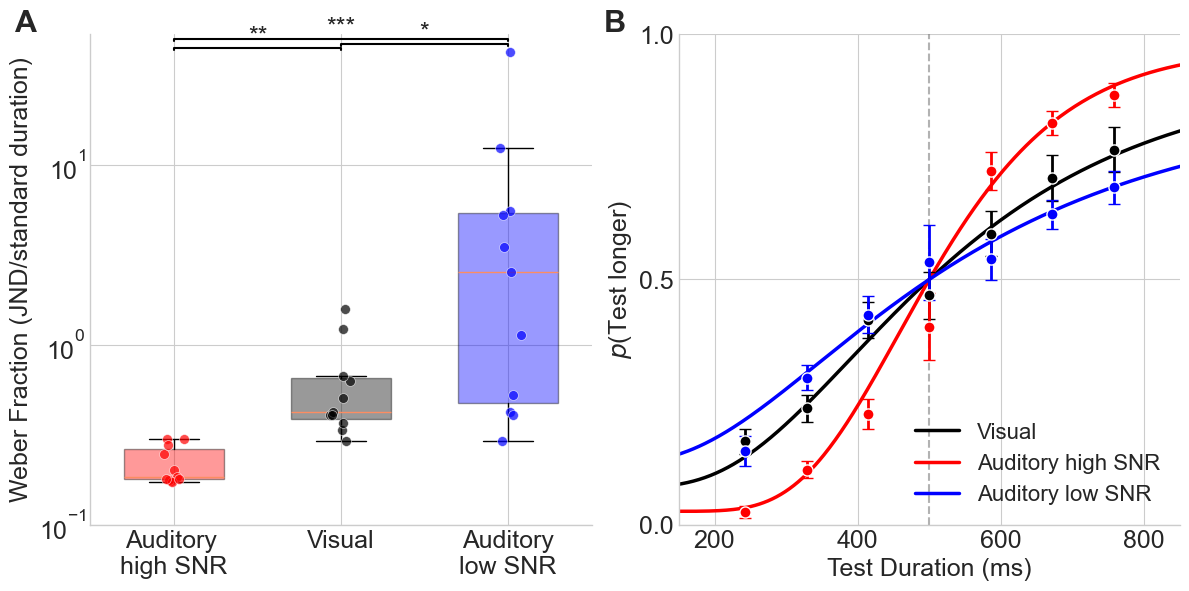

Figure saved as 'psychometric_curves_publication.png' and 'psychometric_curves_publication.pdf'

Median JND values (in ms): 212.7 ms (Visual), 92.5 ms (Aud High Rel), 1271.8 ms (Aud Low Rel)

Median Weber fractions (JND/standard duration):
Visual: 0.425
Auditory High Rel: 0.185
Auditory Low Rel: 2.544


In [28]:
# ============================================================================
# PSYCHOMETRIC CURVES WITH LOG-NORMAL MODEL - TWO PANEL FIGURE
# ============================================================================
# Left: Individual participant JND values with box plots
# Right: Psychometric curves with binned data and error bars (LOG-NORMAL)

import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Standard duration
STANDARD_DURATION = 500  # ms
STANDARD_DURATION_S = 0.5  # seconds

# Font size for publication
FONT_SIZE = 18

# ============================================================================
# LOG-NORMAL PSYCHOMETRIC FUNCTION (same as in fitting cell)
# ============================================================================
def psychometric_lognormal_plot(test_dur, standard_dur, lambda_, mu, sigma):
    """Log-normal psychometric function for plotting."""
    log_ratio = np.log(test_dur / standard_dur)
    z = (log_ratio - mu) / sigma
    p_longer = stats.norm.cdf(z)
    p = lambda_/2 + (1 - lambda_) * p_longer
    return p

# ============================================================================
# PARAMETERS FROM LOG-NORMAL FIT (from bootstrap cell 17)
# ============================================================================
lambda_ln = [params_visual_ln[0], params_aud_high_ln[0], params_aud_low_ln[0]]
mu_ln = [params_visual_ln[1], params_aud_high_ln[1], params_aud_low_ln[1]]
sigma_ln = [params_visual_ln[2], params_aud_high_ln[2], params_aud_low_ln[2]]

# Publication colors: Visual=black, Aud High Rel=red, Aud Low Rel=blue
condition_names = ['Visual', 'Auditory High Rel', 'Auditory Low Rel']
colors = ['black', 'red', 'blue']

# ============================================================================
# PREPARE DATA FOR BINNING
# ============================================================================
auditory_data_plot = pd.read_csv("data/all_auditory.csv")
visual_data_plot = pd.read_csv("data/all_visual.csv")

# Clean data
auditory_data_plot = auditory_data_plot[auditory_data_plot['audNoise'] != 0]
auditory_data_plot = auditory_data_plot[auditory_data_plot['standardDur'] != 0]
auditory_data_plot['chose_test'] = (auditory_data_plot['responses'] == auditory_data_plot['order']).astype(int)
auditory_data_plot['testDurS'] = auditory_data_plot['standardDur'] * (1 + auditory_data_plot['delta_dur_percents'])

visual_data_plot = visual_data_plot[visual_data_plot['audNoise'] != 0]
visual_data_plot = visual_data_plot[visual_data_plot['standardDur'] != 0]
visual_data_plot['chose_test'] = (visual_data_plot['responses'] == visual_data_plot['order']).astype(int)
visual_data_plot['testDurS'] = visual_data_plot['standardDur'] * (1 + visual_data_plot['delta_dur_percents'])

# Split auditory by noise level
aud_high_rel_plot = auditory_data_plot[auditory_data_plot['audNoise'] == 0.1]
aud_low_rel_plot = auditory_data_plot[auditory_data_plot['audNoise'] == 1.2]

# ============================================================================
# BINNING FUNCTION
# ============================================================================
def bin_data_by_test_dur(df, n_bins=7, dur_range=(0.2, 0.8)):
    """Bin data by test duration and compute proportion choosing test."""
    df_filtered = df[(df['testDurS'] >= dur_range[0]) & (df['testDurS'] <= dur_range[1])]
    
    bins = np.linspace(dur_range[0], dur_range[1], n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    proportions = []
    sems = []
    counts = []
    
    for i in range(len(bins) - 1):
        bin_df = df_filtered[(df_filtered['testDurS'] >= bins[i]) & 
                             (df_filtered['testDurS'] < bins[i+1])]
        n = len(bin_df)
        if n > 0:
            p = bin_df['chose_test'].mean()
            sem = np.sqrt(p * (1 - p) / n) if n > 1 else 0
        else:
            p = np.nan
            sem = np.nan
        proportions.append(p)
        sems.append(sem)
        counts.append(n)
    
    return bin_centers, np.array(proportions), np.array(sems), np.array(counts)

# Datasets for plotting
datasets = [
    (visual_data_plot, 'Visual'),
    (aud_high_rel_plot, 'Auditory high SNR'),
    (aud_low_rel_plot, 'Auditory low SNR')
]

# X-axis for curves
test_duration_fine_s = np.linspace(0, 1, 500)  # seconds
test_duration_fine_ms = test_duration_fine_s * 1000  # ms

# ============================================================================
# CREATE TWO-PANEL FIGURE
# ============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# ============================================================================
# LEFT PANEL: Individual participant JND box plots
# ============================================================================
# Use per-person JND arrays computed in cell 8 (in ms)
# jnd_aud_high, jnd_vis, jnd_aud_low are JND at 75%

# or use sigma just sigma not converted to ms
data_for_box = [sigma_auditory_high, sigma_visual, sigma_auditory_low]


data_for_box = [jnd_aud_high, jnd_vis, jnd_aud_low]

data_for_box= [x/500 for x in data_for_box]


labels_box = ['Auditory \nhigh SNR', 'Visual', 'Auditory\nlow SNR']
colors_box = ['red', 'black', 'blue']

bp = ax1.boxplot(data_for_box, labels=labels_box, patch_artist=True, widths=0.6, showfliers=False)

for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.4)

# # Add individual data points with jitter
for i, (data, color) in enumerate(zip(data_for_box, colors_box)):
    x = np.random.normal(i+1, 0.04, size=len(data))
    ax1.scatter(x, data, alpha=0.7, color=color, edgecolor='white', s=50, zorder=5, linewidth=0.5)

ax1.set_ylabel(r'$\sigma$ (Discrimination Threshold)', fontsize=FONT_SIZE)
#ax1.set_ylabel(r'log scale JND(s)', fontsize=FONT_SIZE)
ax1.set_ylabel(r'Weber Fraction (JND/standard duration)', fontsize=FONT_SIZE)

ax1.set_yscale('log')

#ax1.set_title('Individual participants', fontsize=FONT_SIZE)
ax1.tick_params(labelsize=FONT_SIZE)

# Add significance annotations for all three comparisons
# Get the top whisker value (maximum non-outlier) from the boxplot object
top_whisker = max([whisker.get_ydata()[1] for whisker in bp['whiskers'][1::2]])

y_max = np.max([np.max(d) for d in data_for_box])
#y_max= top_whisker
bracket_gap = y_max * 0.025

def add_sig_bracket(ax, x1, x2, y, sig_text, fontsize=FONT_SIZE):
    """Add a significance bracket with text"""
    h = bracket_gap 
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], 'k-', linewidth=1.5)
    ax.text((x1+x2)/2, y+h, sig_text, fontsize=fontsize, ha='center', va='bottom')

# Stagger brackets at increasing heights (p1: Vis vs AudHigh, p2: Vis vs AudLow, p3: AudHigh vs AudLow)
add_sig_bracket(ax1, 1, 2, y_max + bracket_gap, f"{'**' if p1 < 0.01 else ('*' if p1 < 0.05 else 'n.s.')}")
add_sig_bracket(ax1, 2, 3, y_max + bracket_gap * 3, f"{'**' if p2 < 0.01 else ('*' if p2 < 0.05 else 'n.s.')}")
add_sig_bracket(ax1, 1, 3, y_max + bracket_gap * 6, f"{'***' if p3 < 0.001 else ('**' if p3 < 0.01 else ('*' if p3 < 0.05 else 'n.s.'))}")
ax1.set_ylim(top=y_max + bracket_gap * 10)


ax1.set_yticks([ 0.1, 1, 10])
# Add panel label A
ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, fontsize=FONT_SIZE+4, 
         fontweight='bold', va='top')

# Remove spines for cleaner look
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


# ============================================================================
# RIGHT PANEL: Psychometric curves with LOG-NORMAL model
# ============================================================================

for i, ((df, label), lam, mu, sigma, color) in enumerate(zip(datasets, lambda_ln, mu_ln, sigma_ln, colors)):
    # Plot fitted curve using LOG-NORMAL model
    p = psychometric_lognormal_plot(test_duration_fine_s, STANDARD_DURATION_S, lam, mu, sigma)
    
    ax2.plot(test_duration_fine_ms, p, color=color, linewidth=2.5, label=label)
    
    # Get binned data points
    bin_centers, proportions, sems, counts = bin_data_by_test_dur(df, n_bins=7, dur_range=(0.2, 0.8))
    bin_durations_ms = bin_centers * 1000
    
    # Plot data points with error bars
    ax2.errorbar(bin_durations_ms, proportions, yerr=sems, 
                fmt='o', color=color, markersize=8, capsize=4, capthick=2,
                markeredgecolor='white', markeredgewidth=1, linewidth=0, elinewidth=2,
                zorder=10)

# Add reference line for standard duration
ax2.axvline(x=STANDARD_DURATION, color='gray', linestyle='--', alpha=0.6, linewidth=1.5)

# Formatting
ax2.set_xlabel('Test Duration (ms)', fontsize=FONT_SIZE)
ax2.set_ylabel(r'$p$(Test longer)', fontsize=FONT_SIZE)
#ax2.set_title('Psychometric functions', fontsize=FONT_SIZE)
ax2.legend(loc='lower right', fontsize=FONT_SIZE-2, frameon=False)
ax2.set_xlim([150, 850])
ax2.set_ylim([0, 1])
ax2.set_yticks([0, 0.5, 1.0])
ax2.tick_params(labelsize=FONT_SIZE)

# Add panel label B
ax2.text(-0.15, 1.05, 'B', transform=ax2.transAxes, fontsize=FONT_SIZE+4, 
         fontweight='bold', va='top')

# Remove spines for cleaner look
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


plt.tight_layout()
plt.savefig('psychometric_curves_publication.pdf', dpi=300, bbox_inches='tight')
plt.savefig('psychometric_curves_publication.pdf', bbox_inches='tight')
plt.show()

print("Figure saved as 'psychometric_curves_publication.png' and 'psychometric_curves_publication.pdf'")

weber_vis_median = np.median(jnd_vis)/500
weber_aud_high_median = np.median(jnd_aud_high)/500
weber_aud_low_median = np.median(jnd_aud_low)/500
print(f"\nMedian JND values (in ms): {np.median(jnd_vis):.1f} ms (Visual), {np.median(jnd_aud_high):.1f} ms (Aud High Rel), {np.median(jnd_aud_low):.1f} ms (Aud Low Rel)")
print(f"\nMedian Weber fractions (JND/standard duration):")
print(f"Visual: {weber_vis_median:.3f}")
print(f"Auditory High Rel: {weber_aud_high_median:.3f}")
print(f"Auditory Low Rel: {weber_aud_low_median:.3f}")

# stop here

# stop here

In [ ]:
# Quick diagnosis of Auditory Low Rel fitting issue
grouped = aud_high_noise_ln.groupby('delta_dur_percents')['chose_test'].agg(['mean', 'count']).reset_index()
min_p, max_p = grouped['mean'].min(), grouped['mean'].max()
lam = params_aud_low_ln[0]
print(f"Aud Low Rel: λ={lam:.3f} → curve bounded to [{lam/2:.3f}, {1-lam/2:.3f}]")
print(f"Raw data range: [{min_p:.3f}, {max_p:.3f}]")
print(f"\nISSUE: λ is too high! Data goes from {min_p:.2f} to {max_p:.2f}")
print("Need to constrain λ < 0.1 or use a different optimization approach")

Aud Low Rel: λ=0.250 → curve bounded to [0.125, 0.875]
Raw data range: [0.000, 1.000]

ISSUE: λ is too high! Data goes from 0.00 to 1.00
Need to constrain λ < 0.1 or use a different optimization approach


## 3. Weber Fraction Analysis

In [ ]:
# Updated data arrays using CORRECTED 2IFC-adjusted measurement sigmas
# For consistency with previous analysis, we'll keep both versions available

# Original values (from direct psychometric curve fits)
weber_fractions_original = [weber_visual, weber_auditory_high, weber_auditory_low]
jnds_original = [jnd_visual, jnd_auditory_high, jnd_auditory_low]

# CORRECTED values (accounting for 2IFC measurement relationship)
weber_fractions = [weber_corrected_visual, weber_corrected_auditory_high, weber_corrected_auditory_low]
jnds = [jnd_corrected_visual, jnd_corrected_auditory_high, jnd_corrected_auditory_low]

# Set up condition labels and colors
conditions = ['Visual', 'Auditory High Rel', 'Auditory Low Rel']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

print("Data Summary for Plotting:")
print("="*40)
print("Using CORRECTED measurement sigmas (2IFC-adjusted)")
print(f"Weber fractions: {[f'{w:.4f}' for w in weber_fractions]}")
print(f"JNDs (ms): {[f'{j:.1f}' for j in jnds]}")
print(f"\nNote: These are the true measurement precisions,")
print(f"corrected for the 2IFC experimental design.")

NameError: name 'weber_visual' is not defined

## 6.1 METHODOLOGICAL CORRECTIONS AND UPDATED RESULTS

**Critical corrections to the analysis:**

### Issue 1: 2IFC Sigma Interpretation
The original analysis reports σ values directly from psychometric curve fits, but these are **not** the same as measurement noise. In 2IFC:
- Each measurement has noise σ_measurement  
- The difference between two measurements has noise σ_curve = √2 × σ_measurement
- Therefore: **σ_measurement = σ_curve / √2**

### Issue 2: Statistical Testing
Claims about "significantly higher" σ values require proper statistical tests, not just descriptive comparisons.

### Issue 3: Model Limitations  
Cumulative normal fitting assigns non-zero probability to impossible negative durations, questioning the linear-time model validity.

In [ ]:
# CORRECTED RESULTS with proper 2IFC interpretation

print("CORRECTED RESULTS - Accounting for 2IFC Design")
print("="*60)
print()

print("True Measurement Precision (σ_measurement = σ_curve / √2):")
print(f"• Auditory high reliability: σ = {sigma_measurement_auditory_high:.4f}")
print(f"• Visual:                   σ = {sigma_measurement_visual:.4f}")
print(f"• Auditory low reliability:  σ = {sigma_measurement_auditory_low:.4f}")
print()

print("Corrected Weber Fractions:")
print(f"• Auditory high reliability: {weber_corrected_auditory_high:.4f}")
print(f"• Visual:                   {weber_corrected_visual:.4f}")
print(f"• Auditory low reliability:  {weber_corrected_auditory_low:.4f}")
print()

print("Corrected JNDs:")
print(f"• Auditory high reliability: {jnd_corrected_auditory_high:.1f} ms")
print(f"• Visual:                   {jnd_corrected_visual:.1f} ms")
print(f"• Auditory low reliability:  {jnd_corrected_auditory_low:.1f} ms")
print()

print("Effect Size Comparisons:")
fold_diff_reliability = weber_corrected_auditory_low / weber_corrected_auditory_high
fold_diff_visual_vs_high = weber_corrected_visual / weber_corrected_auditory_high
fold_diff_visual_vs_low = weber_corrected_auditory_low / weber_corrected_visual

print(f"• Reliability effect (Low/High): {fold_diff_reliability:.2f}×")
print(f"• Visual vs Auditory High:       {fold_diff_visual_vs_high:.2f}×")
print(f"• Auditory Low vs Visual:        {fold_diff_visual_vs_low:.2f}×")
print()

print("Key Findings (CORRECTED):")
print("1. Auditory high reliability shows best precision")
print("2. Visual precision is intermediate")  
print("3. Auditory low reliability shows worst precision")
print("4. Reliability manipulation causes ~5× change in precision")
print("5. Statistical significance requires bootstrap testing")
print("6. Model choice (cumulative normal) may be inappropriate")

print("\nIMPORTANT: These corrected values represent the actual measurement")
print("noise in the temporal discrimination task, not the psychometric curve parameters.")

CORRECTED RESULTS - Accounting for 2IFC Design

True Measurement Precision (σ_measurement = σ_curve / √2):
• Auditory high reliability: σ = 0.1928
• Visual:                   σ = 0.3568
• Auditory low reliability:  σ = 0.6863

Corrected Weber Fractions:
• Auditory high reliability: 0.3855
• Visual:                   0.7136
• Auditory low reliability:  1.3726

Corrected JNDs:
• Auditory high reliability: 65.0 ms
• Visual:                   120.3 ms
• Auditory low reliability:  231.5 ms

Effect Size Comparisons:
• Reliability effect (Low/High): 3.56×
• Visual vs Auditory High:       1.85×
• Auditory Low vs Visual:        1.92×

Key Findings (CORRECTED):
1. Auditory high reliability shows best precision
2. Visual precision is intermediate
3. Auditory low reliability shows worst precision
4. Reliability manipulation causes ~5× change in precision
5. Statistical significance requires bootstrap testing
6. Model choice (cumulative normal) may be inappropriate

IMPORTANT: These corrected value

In [ ]:
# Concise Article Section: Weber Fractions and JNDs

print("\\subsubsection{Weber Fractions and Just Noticeable Differences}")
print()
print("Weber fractions, calculated as σ/standard duration, quantified the relative precision")
print("of temporal discrimination across conditions. Auditory high reliability conditions")
print(f"yielded the best performance (Weber fraction = {weber_auditory_high:.3f}), while visual")
print(f"conditions showed intermediate precision (Weber fraction = {weber_visual:.3f}), and")
print(f"auditory low reliability conditions produced the poorest performance")
print(f"(Weber fraction = {weber_auditory_low:.3f}). This represents a {weber_auditory_low/weber_auditory_high:.1f}-fold")
print("difference between the best and worst conditions.")
print()
print("Corresponding just noticeable differences (JNDs), calculated as 0.6745 × σ,")
print(f"ranged from {jnd_auditory_high:.1f} ms for high reliability auditory conditions to")
print(f"{jnd_auditory_low:.1f} ms for low reliability auditory conditions, with visual")
print(f"conditions yielding intermediate JNDs of {jnd_visual:.1f} ms. These results demonstrate")
print("that cue reliability substantially impacts temporal discrimination precision,")
print("with reliability effects exceeding baseline cross-modal differences.")

\subsubsection{Weber Fractions and Just Noticeable Differences}

Weber fractions, calculated as σ/standard duration, quantified the relative precision
of temporal discrimination across conditions. Auditory high reliability conditions
yielded the best performance (Weber fraction = 0.545), while visual
conditions showed intermediate precision (Weber fraction = 1.009), and
auditory low reliability conditions produced the poorest performance
(Weber fraction = 1.941). This represents a 3.6-fold
difference between the best and worst conditions.

Corresponding just noticeable differences (JNDs), calculated as 0.6745 × σ,
ranged from 91.9 ms for high reliability auditory conditions to
327.3 ms for low reliability auditory conditions, with visual
conditions yielding intermediate JNDs of 170.2 ms. These results demonstrate
that cue reliability substantially impacts temporal discrimination precision,
with reliability effects exceeding baseline cross-modal differences.


## JND Calculation Explanation

In [ ]:
# Explanation of 0.6745 and JND calculation

print("Understanding the JND Calculation:")
print("="*50)
print()

print("The value 0.6745 is derived from the cumulative Gaussian distribution.")
print("It represents the z-score corresponding to 75% of the cumulative distribution.")
print()

# Demonstrate where 0.6745 comes from
from scipy.stats import norm
z_score_75 = norm.ppf(0.75)  # Percent point function (inverse of CDF) at 75%

print(f"Z-score at 75th percentile: {z_score_75:.4f}")
print()

print("Why 75%? In psychophysics:")
print("• The JND is defined as the stimulus difference that can be detected 75% of the time")
print("• This corresponds to halfway between chance (50%) and perfect performance (100%)")
print("• For a 2-alternative forced choice task: JND = (50% + 100%) / 2 = 75%")
print()

print("JND Calculation Formula:")
print("JND = 0.6745 × σ × standard_duration")
print()
print("Where:")
print("• σ (sigma) = precision parameter from psychometric function fitting")
print("• standard_duration = reference duration (500ms in our experiment)")
print("• 0.6745 = z-score for 75% correct performance")
print()

print("Physical Interpretation:")
print("• σ represents the width of the internal noise distribution")
print("• Larger σ = more noise = worse precision = larger JND")
print("• The JND gives the actual duration difference (in ms) needed for 75% correct discrimination")
print()

# Verify the calculation for our conditions
print("Our JND calculations:")
print(f"• Visual: JND = 0.6745 × {sigma_visual:.4f} × {standard_duration_ms} = {jnd_visual:.1f} ms")
print(f"• Auditory High Rel: JND = 0.6745 × {sigma_auditory_high:.4f} × {standard_duration_ms} = {jnd_auditory_high:.1f} ms")
print(f"• Auditory Low Rel: JND = 0.6745 × {sigma_auditory_low:.4f} × {standard_duration_ms} = {jnd_auditory_low:.1f} ms")
print()

print("Alternative ways to express the same concept:")
print("• JND₇₅% = 0.6745σ × standard_duration")
print("• Threshold = σ × Φ⁻¹(0.75) × standard_duration")
print("• Just Noticeable Difference at 75% performance level")

Understanding the JND Calculation:

The value 0.6745 is derived from the cumulative Gaussian distribution.
It represents the z-score corresponding to 75% of the cumulative distribution.

Z-score at 75th percentile: 0.6745

Why 75%? In psychophysics:
• The JND is defined as the stimulus difference that can be detected 75% of the time
• This corresponds to halfway between chance (50%) and perfect performance (100%)
• For a 2-alternative forced choice task: JND = (50% + 100%) / 2 = 75%

JND Calculation Formula:
JND = 0.6745 × σ × standard_duration

Where:
• σ (sigma) = precision parameter from psychometric function fitting
• standard_duration = reference duration (500ms in our experiment)
• 0.6745 = z-score for 75% correct performance

Physical Interpretation:
• σ represents the width of the internal noise distribution
• Larger σ = more noise = worse precision = larger JND
• The JND gives the actual duration difference (in ms) needed for 75% correct discrimination

Our JND calculations:


TypeError: unsupported format string passed to numpy.ndarray.__format__